# EDA

In [1]:
import os, sys
from datetime import datetime
from collections import Counter

import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

from kgtk.configure_kgtk_notebooks import ConfigureKGTK
from kgtk.functions import kgtk, kypher

In [2]:
data_path = "../kgdata/edges_v4.tsv"
tmp_dir = "../tmp/"
output_dir = "../output/"

if not os.path.isdir(tmp_dir):
    os.mkdir(tmp_dir)

if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

graph_cache = tmp_dir + "wikidata.sqlite3"

In [3]:
os.environ["KGTK_BASH_COMMAND"] = "bash"
os.environ["KGTK_KGTK_COMMAND"] = "~/.venv/bonita-python/bin/kgtk"
# kgtk(f"query --graph-cache {graph_cache} -i {data_path} --as all --limit 3")
# os.system(sqlite3 --version)

In [4]:
df = pd.read_csv(data_path, sep='\t')

## NetworkX

In [5]:
df = pd.read_csv(data_path, sep='\t')
print(df, end="\n\n")
labels = df["label"].unique()
G = nx.from_pandas_edgelist(df, "node1", "node2", edge_attr=True, create_using=nx.DiGraph())
print(labels)

                   node1            label                             node2  \
0       LoiteringEvent_0             type                             Event   
1       LoiteringEvent_0          EventId  506d9d6909e4d5c16793d51ba92bfbc8   
2       LoiteringEvent_0  DescriptionText                               NaN   
3       LoiteringEvent_0        EventType                         loitering   
4       LoiteringEvent_0        StartTime        ^2024-04-17T22:06:50+00:00   
...                  ...              ...                               ...   
354398          ZoneType           domain                        VesselType   
354399          ZoneType            range                            string   
354400      ZoneGeometry             type                    ObjectProperty   
354401      ZoneGeometry           domain                              Zone   
354402      ZoneGeometry            range                          Geometry   

           edge_id  
0             LE_0  
1        

['type' 'EventId' 'DescriptionText' 'EventType' 'StartTime' 'EndTime'
 'StartDistanceFromPort_km' 'StartDistanceFromShore_km'
 'EndDistanceFromPort_km' 'EndDistanceFromShore_km' 'Location'
 'EventGeometry' 'HasParticipant' 'ValidatedBy' 'ExplainedBy'
 'HasProvenance' 'BehaviorType' 'UncertaintyNote' 'AvgSpeed_knots'
 'PatternGeometry' 'UnexplainedByWeatherOrPort' 'ObservationId' 'MMSI'
 'Lat' 'Lon' 'Speed' 'Course' 'Timestamp' 'DistanceFromPortKM'
 'DistanceFromShoreKM' 'Source' 'SSVID' 'VesselName' 'CallSign' 'Flag'
 'VesselTypeId' 'GroupType' 'HasMember' 'AsWKT' 'CentroidLat'
 'CentroidLon' 'CRS' 'PortName' 'BerthGeometry' 'FishingEffortScore'
 'GearType' 'ZoneCode' 'ZoneName' 'ZoneType' 'ZoneGeometry' 'SourceID'
 'SourceName' 'SourceType' 'SourceURL' 'MemberVessel' 'MembershipRole'
 'MemberOf' 'PatternTypeID' 'PatternTypeName' 'subClassOf' 'domain'
 'range' ' type']


In [6]:
prefix_edge_id = df["edge_id"].apply(lambda x: x.split('_')[0]).unique()
print(len(prefix_edge_id))
print(prefix_edge_id)

8551
['LE' 'AIS' 'VI' ... 'GM' 'PT' 'schema']


## type

In [7]:
print(df[df["label"] == "type"].node2.unique(), end="\n\n")
print(df[df["label"] == "TypeName"])

['Event' 'AISObservation' 'VesselIdentity' 'Group' 'Geometry' 'Zone'
 'ProvenanceSource' 'GroupMembership' 'PatternType' 'DatatypeProperty'
 'ObjectProperty']

Empty DataFrame
Columns: [node1, label, node2, edge_id]
Index: []


## subclass

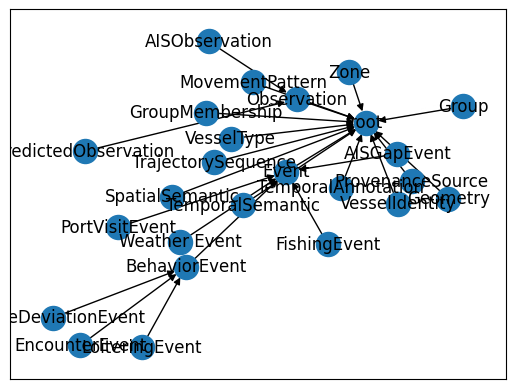

In [8]:
subclass_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get("label") == "subClassOf"]
subclass_G = G.edge_subgraph(subclass_edges).copy()
nx.draw_networkx(subclass_G)

In [9]:
domain_lv1 = {u for u, v, d in subclass_G.edges(data=True) if v == "root"}
has_child = []
for node in domain_lv1:
    if subclass_G.degree(node) != 1:
        has_child.append(node)

print(domain_lv1)
print(has_child)

{'GroupMembership', 'Geometry', 'SpatialSemantic', 'TemporalAnnotation', 'Observation', 'MovementPattern', 'TemporalSemantic', 'TrajectorySequence', 'Zone', 'ProvenanceSource', 'Event', 'VesselIdentity', 'Group', 'VesselType'}
['Observation', 'Event']


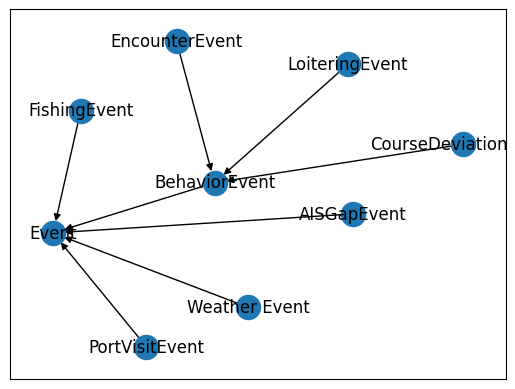

In [10]:
nx.draw_networkx(subclass_G.subgraph({"Event"} | nx.ancestors(subclass_G, "Event")))

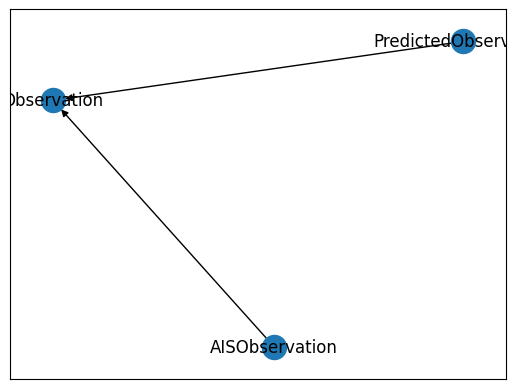

In [11]:
nx.draw_networkx(subclass_G.subgraph({"Observation"} | nx.ancestors(subclass_G, "Observation")))

## type

In [12]:
print(df[df["label"] == "type"].node2.unique())

['Event' 'AISObservation' 'VesselIdentity' 'Group' 'Geometry' 'Zone'
 'ProvenanceSource' 'GroupMembership' 'PatternType' 'DatatypeProperty'
 'ObjectProperty']


In [13]:
print(df[(df["label"] == "type") & (df["node2"] == "Event")])

                   node1 label  node2  edge_id
0       LoiteringEvent_0  type  Event     LE_0
21      LoiteringEvent_1  type  Event    LE_21
42      LoiteringEvent_2  type  Event    LE_42
63      LoiteringEvent_3  type  Event    LE_63
84      LoiteringEvent_4  type  Event    LE_84
...                  ...   ...    ...      ...
353881  FishingEvent_326  type  Event  FE_5868
353899  FishingEvent_327  type  Event  FE_5886
353917  FishingEvent_328  type  Event  FE_5904
353935  FishingEvent_329  type  Event  FE_5922
353953  FishingEvent_330  type  Event  FE_5940

[1698 rows x 4 columns]


## domain

In [14]:
domain_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get("label") == "domain"]
domain_G = G.edge_subgraph(domain_edges).copy()

domain_root = df[df["label"] == "domain"]["node2"].unique()
print(domain_root)

['Event' 'BehaviorEvent' 'EncounterEvent' 'LoiteringEvent'
 'CourseDeviationEvent' 'AISGapEvent' 'FishingEvent' 'PortVisitEvent'
 'WeatherEvent' 'Observation' 'AISObservation' 'PredictedObservation'
 'TrajectorySequence' 'VesselIdentity' 'Group' 'GroupMembership'
 'Geometry' 'PatternType' 'MovementPattern' 'TemporalAnnotation'
 'TemporalSemantic' 'SpatialSemantic' 'ProvenanceSource' 'VesselType'
 'Zone']


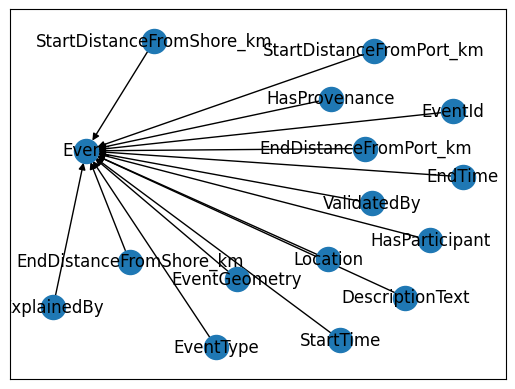

In [15]:
event_edges = [(u, v) for u, v, d in domain_G.edges(data=True) if v == "Event"]
event_G = domain_G.edge_subgraph(event_edges)
nx.draw_networkx(event_G)

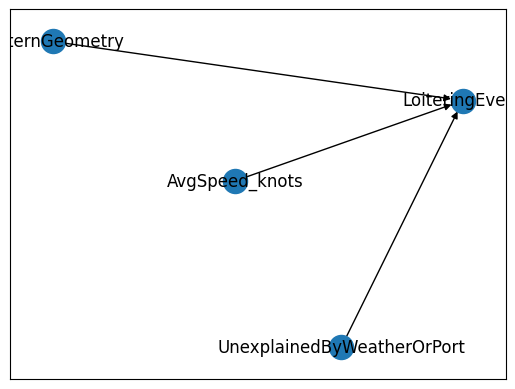

In [16]:
loitering_edges = [(u, v) for u, v, d in domain_G.edges(data=True) if v == "LoiteringEvent"]
loitering_G = domain_G.edge_subgraph(loitering_edges)
nx.draw_networkx(loitering_G)

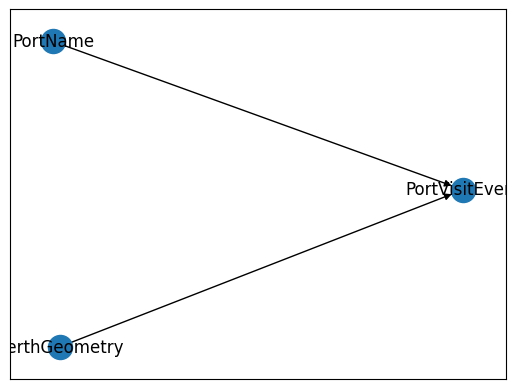

In [17]:
portvisit_edges = [(u, v) for u, v, d in domain_G.edges(data=True) if v == "PortVisitEvent"]
portvisit_G = domain_G.edge_subgraph(portvisit_edges)
nx.draw_networkx(portvisit_G)

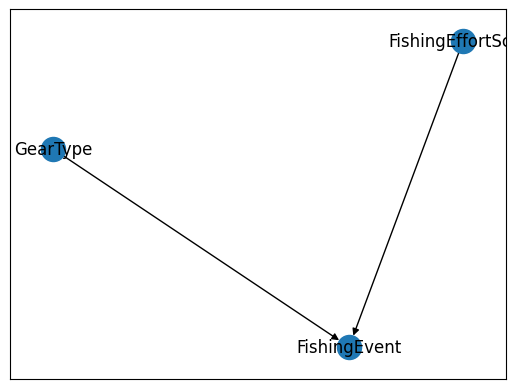

In [18]:
fishing_edges = [(u, v) for u, v, d in domain_G.edges(data=True) if v == "FishingEvent"]
fishing_G = domain_G.edge_subgraph(fishing_edges)
nx.draw_networkx(fishing_G)

## Vessel

In [19]:
print(df[df["node2"] == "VesselIdentity"], end="\n\n")
print(df[df["node1"] == "VesselIdentity_0"], end="\n\n")
print(df[df["label"] == "SSVID"], end="\n\n")
print(df[df["label"] == "VesselTypeId"])

                    node1   label           node2     edge_id
319703   VesselIdentity_0    type  VesselIdentity        VI_0
319710   VesselIdentity_1    type  VesselIdentity        VI_7
319717   VesselIdentity_2    type  VesselIdentity       VI_14
319724   VesselIdentity_3    type  VesselIdentity       VI_21
319731   VesselIdentity_4    type  VesselIdentity       VI_28
319738   VesselIdentity_5    type  VesselIdentity       VI_35
319745   VesselIdentity_6    type  VesselIdentity       VI_42
319752   VesselIdentity_7    type  VesselIdentity       VI_49
319759   VesselIdentity_8    type  VesselIdentity       VI_56
319766   VesselIdentity_9    type  VesselIdentity       VI_63
319773  VesselIdentity_10    type  VesselIdentity       VI_70
319780  VesselIdentity_11    type  VesselIdentity       VI_77
319787  VesselIdentity_12    type  VesselIdentity       VI_84
319794  VesselIdentity_13    type  VesselIdentity       VI_91
319801  VesselIdentity_14    type  VesselIdentity       VI_98
319808  

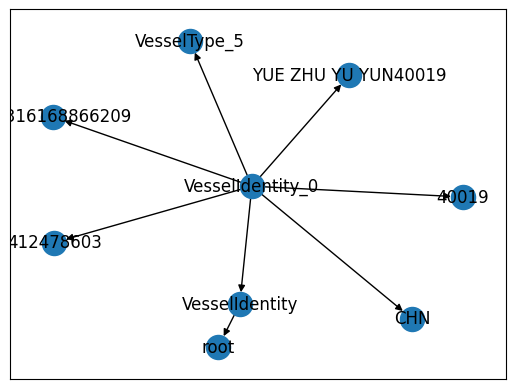

In [20]:
vessel0_G = G.subgraph(nx.predecessor(G, "VesselIdentity_0"))
nx.draw_networkx(vessel0_G, with_labels=True)

In [21]:
df[df["label"] == "MemberVessel"]

,node1,label,node2,edge_id
354052,GroupMembership_0,MemberVessel,VesselIdentity_15,GM_1
354056,GroupMembership_1,MemberVessel,VesselIdentity_12,GM_5
354060,GroupMembership_2,MemberVessel,VesselIdentity_1,GM_9
354064,GroupMembership_3,MemberVessel,VesselIdentity_0,GM_13
354068,GroupMembership_4,MemberVessel,VesselIdentity_10,GM_17
354072,GroupMembership_5,MemberVessel,VesselIdentity_5,GM_21
354076,GroupMembership_6,MemberVessel,VesselIdentity_7,GM_25


## DescriptionText

In [22]:
print(df[df["label"] == "DescriptionText"], end="\n\n")
print(Counter(df[df["label"] == "DescriptionText"].node1.apply(lambda x: x.split('_')).apply(lambda x: x[0])))

                   node1            label node2  edge_id
2       LoiteringEvent_0  DescriptionText   NaN     LE_2
23      LoiteringEvent_1  DescriptionText   NaN    LE_23
44      LoiteringEvent_2  DescriptionText   NaN    LE_44
65      LoiteringEvent_3  DescriptionText   NaN    LE_65
86      LoiteringEvent_4  DescriptionText   NaN    LE_86
...                  ...              ...   ...      ...
353883  FishingEvent_326  DescriptionText   NaN  FE_5870
353901  FishingEvent_327  DescriptionText   NaN  FE_5888
353919  FishingEvent_328  DescriptionText   NaN  FE_5906
353937  FishingEvent_329  DescriptionText   NaN  FE_5924
353955  FishingEvent_330  DescriptionText   NaN  FE_5942

[1698 rows x 4 columns]

Counter({'PortVisitEvent': 1091, 'FishingEvent': 331, 'LoiteringEvent': 276})


## AISObservation

In [23]:
print(df[(df["label"] == "type") & (df["node2"] == "AISObservation")], end="\n\n")
print(df[df["label"] == "ObservationId"])
print(df[df["node1"] == "AISObservation_0"])

                       node1 label           node2     edge_id
5796        AISObservation_0  type  AISObservation       AIS_0
5807        AISObservation_1  type  AISObservation      AIS_11
5818        AISObservation_2  type  AISObservation      AIS_22
5829        AISObservation_3  type  AISObservation      AIS_33
5840        AISObservation_4  type  AISObservation      AIS_44
...                      ...   ...             ...         ...
319648  AISObservation_28532  type  AISObservation  AIS_313852
319659  AISObservation_28533  type  AISObservation  AIS_313863
319670  AISObservation_28534  type  AISObservation  AIS_313874
319681  AISObservation_28535  type  AISObservation  AIS_313885
319692  AISObservation_28536  type  AISObservation  AIS_313896

[28537 rows x 4 columns]

                       node1          label  node2     edge_id
5797        AISObservation_0  ObservationId      0       AIS_1
5808        AISObservation_1  ObservationId      1      AIS_12
5819        AISObservation_2

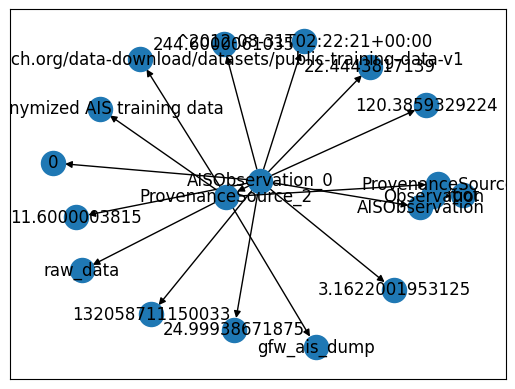

In [24]:
ais0_G = G.subgraph(nx.predecessor(G, "AISObservation_0"))
nx.draw_networkx(ais0_G, with_labels=True)

In [25]:
print(df[(df["label"] == "MMSI") & (df["node2"] == "132058711150033")])

                       node1 label            node2     edge_id
5798        AISObservation_0  MMSI  132058711150033       AIS_2
5809        AISObservation_1  MMSI  132058711150033      AIS_13
5820        AISObservation_2  MMSI  132058711150033      AIS_24
37401    AISObservation_2873  MMSI  132058711150033   AIS_31605
37412    AISObservation_2874  MMSI  132058711150033   AIS_31616
...                      ...   ...              ...         ...
243365  AISObservation_21597  MMSI  132058711150033  AIS_237569
249162  AISObservation_22124  MMSI  132058711150033  AIS_243366
249239  AISObservation_22131  MMSI  132058711150033  AIS_243443
249250  AISObservation_22132  MMSI  132058711150033  AIS_243454
319788     VesselIdentity_12  MMSI  132058711150033       VI_85

[134 rows x 4 columns]


# Trajectory

In [26]:
mmsies = df[df["label"] == "MMSI"].node2.unique()

def trajectory_plot(mmsi: str):
    def mmsi2ais(mmsi: str):
        tmp = df[(df["label"] == "MMSI") & (df["node2"] == mmsi)]
        return tmp[tmp["edge_id"].apply(lambda x: x.startswith("AIS"))].node1.unique()

    def ais2timestamp(ais: str):
        tmp = df[df["node1"] == ais]
        return tmp[tmp["label"] == "Timestamp"].node2.values[0]

    def ais2latlon(ais: str):
        tmp = df[df["node1"] == ais]
        lat = float(tmp[tmp["label"] == "Lat"].node2.values[0])
        lon = float(tmp[tmp["label"] == "Lon"].node2.values[0])
        return lat, lon

    ais_lst = mmsi2ais(mmsi)
    latlon = [(ais2timestamp(ais), ) + ais2latlon(ais) for ais in ais_lst]
    latlon = sorted(latlon, key=lambda x: x[0])

    lats = np.array([ll[1] for ll in latlon])
    lons = np.array([ll[2] for ll in latlon])

    lat_min, lat_max = lats.min() - 0.01, lats.max() + 0.01
    lon_min, lon_max = lons.min() - 0.01, lons.max() + 0.01

    world_map = Basemap(projection="mill",
                        lon_0=0,
                        llcrnrlat=lat_min,
                        urcrnrlat=lat_max,
                        llcrnrlon=lon_min,
                        urcrnrlon=lon_max,
                        resolution='i',)
    world_map.drawcoastlines()
    world_map.drawmapboundary(fill_color="lightblue")
    world_map.fillcontinents(color="lightgray", lake_color="lightblue")
    x, y = world_map(lons, lats)

    u = np.diff(x); v = np.diff(y)
    x0 = x[:-1]; y0 = y[:-1]

    world_map.quiver(x0, y0, u, v, scale=1, scale_units="xy", angles="xy",
                     color="white", width=0.03)
    world_map.plot(x, y, "ko-", markersize=4, alpha=0.6)
    world_map.scatter(x[0], y[0], c="green", s=80)
    world_map.scatter(x[-1], y[-1], c="yellow", s=80)
    plt.show()

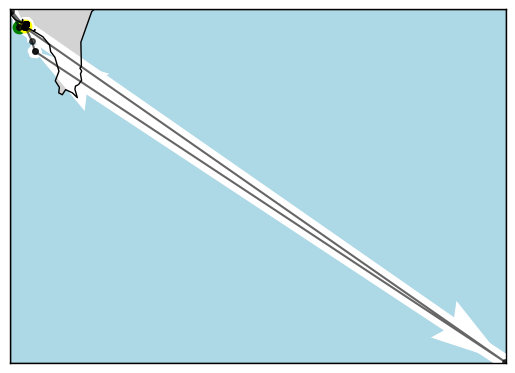

In [27]:
trajectory_plot(mmsies[0])

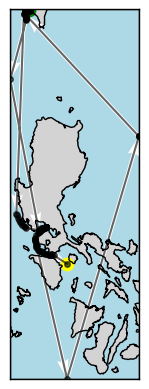

In [28]:
trajectory_plot(mmsies[1])

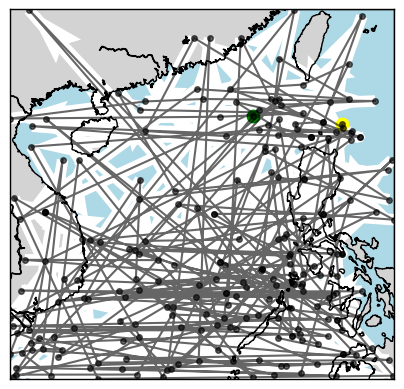

In [29]:
trajectory_plot(mmsies[2])

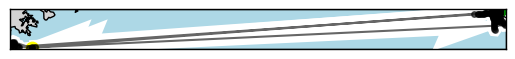

In [30]:
trajectory_plot(mmsies[3])

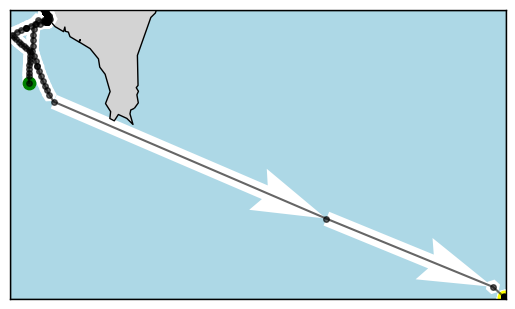

In [31]:
trajectory_plot(mmsies[4])

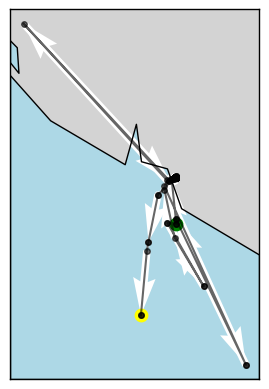

In [32]:
trajectory_plot(mmsies[5])

## Port

In [33]:
print(df[df["label"] == "PortName"], end="\n\n")
print(df[df["label"] == "PortName"].node2.unique(), end="\n\n")
print(df[df["node1"] == "PortVisitEvent_0"])

                      node1     label       node2    edge_id
328391     PortVisitEvent_0  PortName      LIUQIU     PVE_16
328409     PortVisitEvent_1  PortName    DONGGANG     PVE_34
328427     PortVisitEvent_2  PortName    DONGGANG     PVE_52
328445     PortVisitEvent_3  PortName    DONGGANG     PVE_70
328463     PortVisitEvent_4  PortName    DONGGANG     PVE_88
...                     ...       ...         ...        ...
347939  PortVisitEvent_1086  PortName  CHEKLAPKOK  PVE_19564
347957  PortVisitEvent_1087  PortName      BEIHAI  PVE_19582
347975  PortVisitEvent_1088  PortName   KAOHSIUNG  PVE_19600
347993  PortVisitEvent_1089  PortName      ZHUHAI  PVE_19618
348011  PortVisitEvent_1090  PortName   GUANGZHOU  PVE_19636

[1091 rows x 4 columns]

['LIUQIU' 'DONGGANG' 'KAOHSIUNG' nan 'SUAO' 'GUANGZHOU' 'HSINTA'
 'CHN-2324' 'ZHONGYUN' 'ZHUHAI' 'HONGKONG' 'QUANZHOU' 'LAMMA ISLAND'
 'XIAMEN' 'YANTIAN' 'GUISHAN' 'SHENZHEN' 'MACAU' 'BEIHAI' 'CHN-2163'
 'TIESHAN' 'SPRATLY ISLANDS' 'FANGCHENG

## Event Geometry

In [34]:
print(df[df["label"] == "EventGeometry"], end="\n\n")
print(df[df["node1"] == "Geometry_261"])

                   node1          label          node2  edge_id
11      LoiteringEvent_0  EventGeometry   Geometry_261    LE_11
32      LoiteringEvent_1  EventGeometry   Geometry_262    LE_32
53      LoiteringEvent_2  EventGeometry   Geometry_263    LE_53
74      LoiteringEvent_3  EventGeometry   Geometry_264    LE_74
95      LoiteringEvent_4  EventGeometry   Geometry_265    LE_95
...                  ...            ...            ...      ...
353892  FishingEvent_326  EventGeometry  Geometry_1954  FE_5879
353910  FishingEvent_327  EventGeometry  Geometry_1955  FE_5897
353928  FishingEvent_328  EventGeometry  Geometry_1956  FE_5915
353946  FishingEvent_329  EventGeometry  Geometry_1957  FE_5933
353964  FishingEvent_330  EventGeometry  Geometry_1958  FE_5951

[1698 rows x 4 columns]

               node1        label  \
319885  Geometry_261         type   
319886  Geometry_261        AsWKT   
319887  Geometry_261  CentroidLat   
319888  Geometry_261  CentroidLon   
319889  Geometry_261 

In [35]:
print(df[df["label"] == "EventGeometry"].node1.apply(lambda x: x.split('_')[0]).unique(), end="\n\n")
print(Counter(df[df["label"] == "EventGeometry"].node1.apply(lambda x: x.split('_')[0])))

['LoiteringEvent' 'PortVisitEvent' 'FishingEvent']

Counter({'PortVisitEvent': 1091, 'FishingEvent': 331, 'LoiteringEvent': 276})


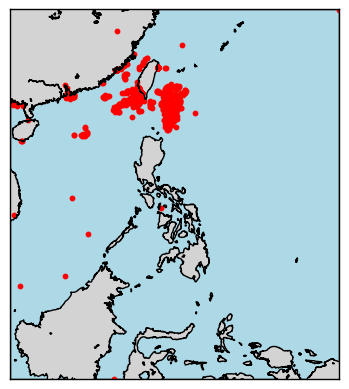

In [36]:
def geometry2latlon(geometry: str):
        tmp = df[df["node1"] == geometry]
        lat = float(tmp[tmp["label"] == "CentroidLat"].node2.values[0])
        lon = float(tmp[tmp["label"] == "CentroidLon"].node2.values[0])
        return lat, lon

geometries = sorted(df[df["label"] == "CentroidLat"].node1.unique())
latlon = [geometry2latlon(geometry) for geometry in geometries]

lats = np.array([ll[0] for ll in latlon])
lons = np.array([ll[1] for ll in latlon])

lat_min, lat_max = lats.min() - 0.01, lats.max() + 0.01
lon_min, lon_max = lons.min() - 0.01, lons.max() + 0.01

world_map = Basemap(projection="mill",
                    lon_0=0,
                    llcrnrlat=lat_min,
                    urcrnrlat=lat_max,
                    llcrnrlon=lon_min,
                    urcrnrlon=lon_max,
                    resolution='i',)
world_map.drawcoastlines()
world_map.drawmapboundary(fill_color="lightblue")
world_map.fillcontinents(color="lightgray", lake_color="lightblue")
x, y = world_map(lons, lats)

world_map.scatter(x, y, c="red", s=10)
plt.show()

In [37]:
def geometry_plot(prefix_event: set):
    def geometry2latlon(geometry: str):
        tmp = df[df["node1"] == geometry]
        lat = float(tmp[tmp["label"] == "CentroidLat"].node2.values[0])
        lon = float(tmp[tmp["label"] == "CentroidLon"].node2.values[0])
        return lat, lon
        
    tmp = df[df["label"] == "EventGeometry"]
    geometries = tmp[tmp.node1.apply(lambda x: x.split('_')[0] in prefix_event)].node2.to_list()
    latlon = [geometry2latlon(geometry) for geometry in geometries]

    lats = np.array([ll[0] for ll in latlon])
    lons = np.array([ll[1] for ll in latlon])

    lat_min, lat_max = lats.min() - 0.01, lats.max() + 0.01
    lon_min, lon_max = lons.min() - 0.01, lons.max() + 0.01

    world_map = Basemap(projection="mill",
                        lon_0=0,
                        llcrnrlat=lat_min,
                        urcrnrlat=lat_max,
                        llcrnrlon=lon_min,
                        urcrnrlon=lon_max,
                        resolution='i',)
    world_map.drawcoastlines()
    world_map.drawmapboundary(fill_color="lightblue")
    world_map.fillcontinents(color="lightgray", lake_color="lightblue")
    x, y = world_map(lons, lats)
    
    world_map.scatter(x, y, c="red", s=10)
    plt.show()

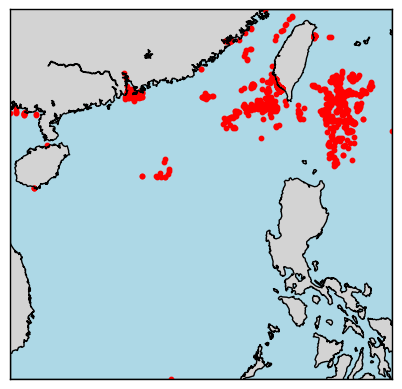

In [38]:
geometry_plot({"LoiteringEvent", "PortVisitEvent", "FishingEvent"})

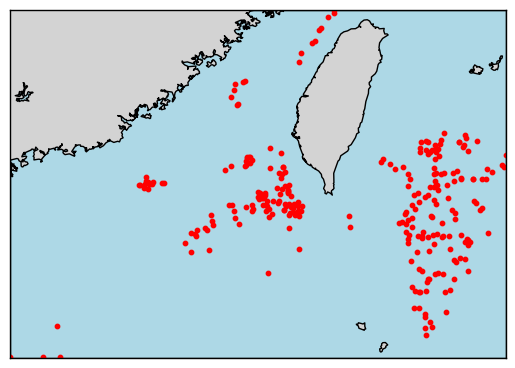

In [39]:
geometry_plot({"LoiteringEvent"})

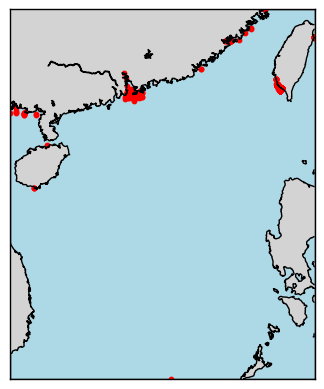

In [40]:
geometry_plot({"PortVisitEvent"})

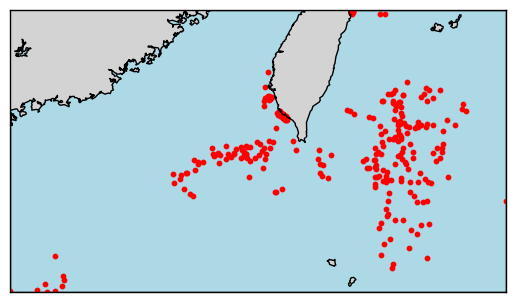

In [41]:
geometry_plot({"FishingEvent"})

## Vessel Event Gemetry

In [42]:
def vessel_event_plot(vessel: str):
    event_color = {"LoiteringEvent": "green", "PortVisitEvent": "purple", "FishingEvent": "red"}
    
    def geometry2latlon(geometry: str):
        tmp = df[df["node1"] == geometry]
        lat = float(tmp[tmp["label"] == "CentroidLat"].node2.values[0])
        lon = float(tmp[tmp["label"] == "CentroidLon"].node2.values[0])
        return lat, lon
    
    def event2custom(event: str):
        tmp = df[df["node1"] == event]
        start = tmp[tmp["label"] == "StartTime"].node2.values[0]
        lat, lon = geometry2latlon(tmp[tmp["label"] == "EventGeometry"].node2.values[0])
        return start, lat, lon, event_color[event.split('_')[0]]
        
    events = df[(df["label"] == "HasParticipant") & (df["node2"] == vessel)].node1.unique().tolist()
    latlon = [event2custom(event) for event in events]
    latlon = sorted(latlon, key=lambda x: x[0])

    lats = np.array([ll[1] for ll in latlon])
    lons = np.array([ll[2] for ll in latlon])
    colors = np.array([ll[3] for ll in latlon])

    lat_min, lat_max = lats.min() - 0.01, lats.max() + 0.01
    lon_min, lon_max = lons.min() - 0.01, lons.max() + 0.01

    world_map = Basemap(projection="mill",
                        lon_0=0,
                        llcrnrlat=lat_min,
                        urcrnrlat=lat_max,
                        llcrnrlon=lon_min,
                        urcrnrlon=lon_max,
                        resolution='i',)
    world_map.drawcoastlines()
    world_map.drawmapboundary(fill_color="lightblue")
    world_map.fillcontinents(color="lightgray", lake_color="lightblue")
    x, y = world_map(lons, lats)

    u = np.diff(x); v = np.diff(y)
    x0 = x[:-1]; y0 = y[:-1]

    world_map.quiver(x0, y0, u, v, scale=1, scale_units="xy", angles="xy",
                     color="white", width=0.03)
    world_map.plot(x, y, "k-", markersize=4, alpha=0.6)
    world_map.scatter(x, y, c=colors)
    plt.show()

In [43]:
vessels = df[(df["label"] == "type") & (df["node2"] == "VesselIdentity")].node1.unique()
print(vessels)

['VesselIdentity_0' 'VesselIdentity_1' 'VesselIdentity_2'
 'VesselIdentity_3' 'VesselIdentity_4' 'VesselIdentity_5'
 'VesselIdentity_6' 'VesselIdentity_7' 'VesselIdentity_8'
 'VesselIdentity_9' 'VesselIdentity_10' 'VesselIdentity_11'
 'VesselIdentity_12' 'VesselIdentity_13' 'VesselIdentity_14'
 'VesselIdentity_15' 'VesselIdentity_16']


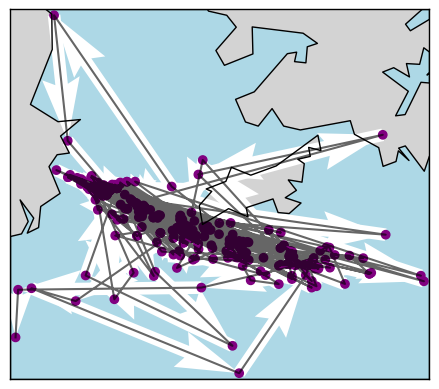

In [44]:
vessel_event_plot(vessels[0])

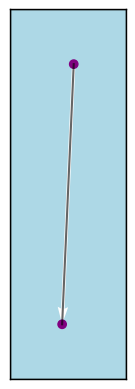

In [45]:
vessel_event_plot(vessels[1])

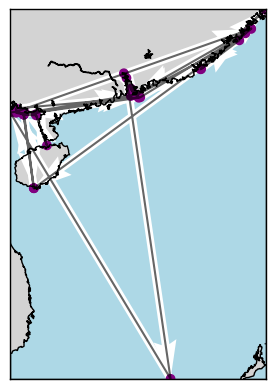

In [46]:
vessel_event_plot(vessels[2])

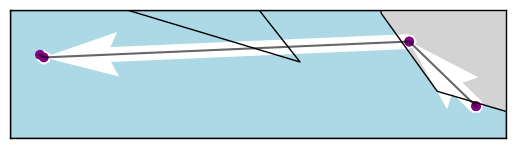

In [47]:
vessel_event_plot(vessels[3])

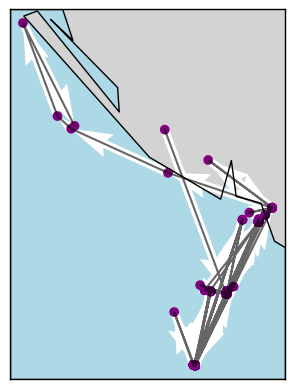

In [48]:
vessel_event_plot(vessels[4])

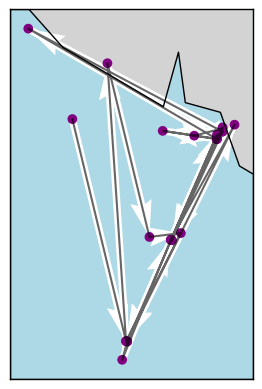

In [49]:
vessel_event_plot(vessels[5])

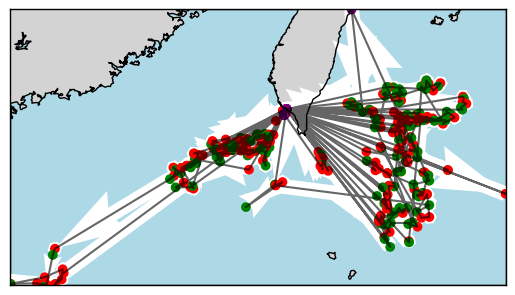

In [50]:
vessel_event_plot(vessels[6])

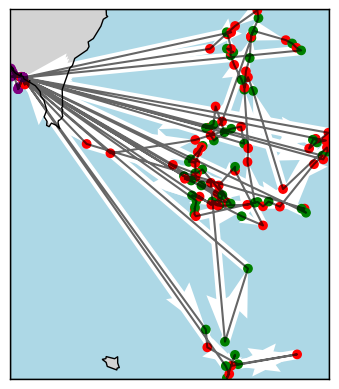

In [51]:
vessel_event_plot(vessels[7])

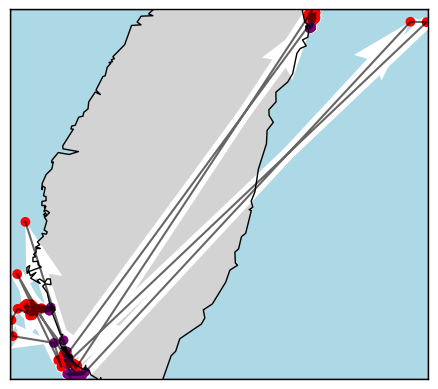

In [52]:
vessel_event_plot(vessels[8])

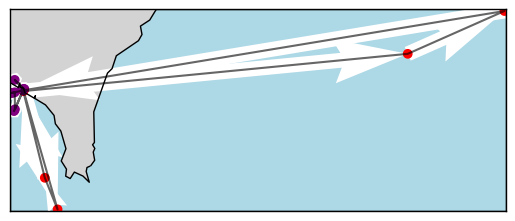

In [53]:
vessel_event_plot(vessels[9])

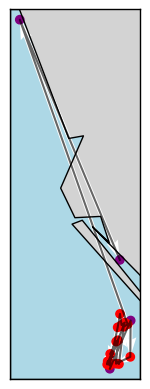

In [54]:
vessel_event_plot(vessels[10])

## Events Statistics

In [ ]:
# ()))

In [56]:
print(df[df["node1"] == "LoiteringEvent_0"])

               node1                       label  \
0   LoiteringEvent_0                        type   
1   LoiteringEvent_0                     EventId   
2   LoiteringEvent_0             DescriptionText   
3   LoiteringEvent_0                   EventType   
4   LoiteringEvent_0                   StartTime   
5   LoiteringEvent_0                     EndTime   
6   LoiteringEvent_0    StartDistanceFromPort_km   
7   LoiteringEvent_0   StartDistanceFromShore_km   
8   LoiteringEvent_0      EndDistanceFromPort_km   
9   LoiteringEvent_0     EndDistanceFromShore_km   
10  LoiteringEvent_0                    Location   
11  LoiteringEvent_0               EventGeometry   
12  LoiteringEvent_0              HasParticipant   
13  LoiteringEvent_0                 ValidatedBy   
14  LoiteringEvent_0                 ExplainedBy   
15  LoiteringEvent_0               HasProvenance   
16  LoiteringEvent_0                BehaviorType   
17  LoiteringEvent_0             UncertaintyNote   
18  Loiterin

In [58]:
print(Counter(df[df["label"] == "DescriptionText"].node1.apply(lambda x: x.split('_')).apply(lambda x: x[0])))

Counter({'PortVisitEvent': 1091, 'FishingEvent': 331, 'LoiteringEvent': 276})


()))

In [60]:
# ()
labels = {"LoiteringEvent", "PortVisitEvent", "FishingEvent"}
domains = [
    "StartDistanceFromPort_km",
    "StartDistanceFromShore_km",
    "EndDistanceFromPort_km",
    "EndDistanceFromShore_km",
]

def get_statistics(event_name: str):
    def get_node2(node1: str, label: str):
        return float(df[(df["node1"] == node1) & (df["label"] == label)].node2.values[0])
    
    tmp = df[df["node1"].apply(lambda x: x.startswith(event_name + '_'))]
    events = tmp.node1.unique()
    
    size = len(events)
    value_sum = np.zeros(len(domains)); value_sqr_sum = np.zeros(len(domains))
    
    for event in events:
        for i, domain in enumerate(domains):
            value = get_node2(event, domain)
            value_sum[i] += value
            value_sqr_sum[i] += value * value
            
    # V(x) = E(x^2) - E(x)^2
    return value_sum, value_sqr_sum - value_sum ** 2

levent = get_statistics("LoiteringEvent")
pevent = get_statistics("PortVisitEvent")
fevent = get_statistics("FishingEvent")

print("LoiteringEvents")
print('\t', domains)
print("AVG: ", levent[0].tolist())
print("VAR: ", levent[1].tolist(), end="\n\n")

print("PortVisitEvents")
print('\t', domains)
print("AVG: ", pevent[0].tolist())
print("VAR: ", pevent[1].tolist(), end="\n\n")

print("FishingEvents")
print('\t', domains)
print("AVG: ", fevent[0].tolist())
print("VAR: ", fevent[1].tolist(), end="\n\n")

LoiteringEvents
	 ['StartDistanceFromPort_km', 'StartDistanceFromShore_km', 'EndDistanceFromPort_km', 'EndDistanceFromShore_km']
AVG:  [53188.00702199999, 30545.0, 53119.61611400001, 30568.0]
VAR:  [-2815773851.9054375, -928960864.0, -2808474636.514067, -930341906.0]

PortVisitEvents
	 ['StartDistanceFromPort_km', 'StartDistanceFromShore_km', 'EndDistanceFromPort_km', 'EndDistanceFromShore_km']
AVG:  [0.0, 2800.0, 0.0, 2900.0]
VAR:  [0.0, -7820708.0, 0.0, -8391170.0]

FishingEvents
	 ['StartDistanceFromPort_km', 'StartDistanceFromShore_km', 'EndDistanceFromPort_km', 'EndDistanceFromShore_km']
AVG:  [53157.08807600001, 29578.0, 51828.58996, 29946.0]
VAR:  [-2811955245.883673, -870511952.0, -2672870856.9851055, -892313770.0]

